In [1]:
# ① tsfresh 라이브러리 설치
# !pip install tsfresh

In [2]:
# # ② 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
# import os
# os.kill(os.getpid(), 9)

In [3]:
# ③ robot_execution_failures 데이터셋 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [21]:
timeseries.groupby('id').count()

,time,F_x,F_y,F_z,T_x,T_y,T_z
id,,,,,,,
1,15,15,15,15,15,15,15
2,15,15,15,15,15,15,15
3,15,15,15,15,15,15,15
4,15,15,15,15,15,15,15
5,15,15,15,15,15,15,15
...,...,...,...,...,...,...,...
84,15,15,15,15,15,15,15
85,15,15,15,15,15,15,15
86,15,15,15,15,15,15,15


In [4]:
# ④ 추가로 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
%config InlineBackend.figure_format = 'retina'

In [5]:
# ⑤ 데이터셋 가공
def custom_classification_split(x, y, test_size=0.3):
    num_true = int(y.sum()*test_size)           # int(21 * 0.3) = 6
    num_false = int((len(y)-y.sum())*test_size) # int((88 - 21)*0.3) = 20

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    # y==False인것과 y==True인것의 인덱스값을 리스트로 변환하여 더해줍니다.
    # y[y==False].head(num_false).index.to_list()는 19~38까지의 값이 리스트로
    # y[y==True].head(num_true).index.to_list()는 1~6까지의 값이 리스트로 
    # id_list는 20~39 + 2~7이 더해진 리스트입니다.

    y_train = y.drop(id_list)                            # y에서 id_list를 drop합니다.  
    y_test = y.iloc[id_list].sort_index()                # 20~39, 2~7이 합쳐진 리스트를 정렬합니다.
    X_train = x[~x['id'].isin(id_list)] # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용하고 물결표시는 안에 조건이 포함되어 있지 않는것만 사용하는 것입니다.
    X_test = x[x['id'].isin(id_list)]   # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용

    return X_train, y_train, X_test, y_test

In [6]:
# 커스텀한 함수를 적용한 데이터셋이 어떤 차이가 있는지 확인해봅시다.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y)
print(X_train)
print('-'*50)
print(y_train)
print('-'*50)
print(X_test)
print('-'*50)
print(y_test)


      id  time  F_x  F_y  F_z  T_x  T_y  T_z
90     7     0   -3    1   53  -10   -4    0
91     7     1    0   -2   65   -4   -1    0
92     7     2   -1   -1   56   -7   -3    0
93     7     3    0   -2   60   -6    0    0
94     7     4   -1   -1   57   -7   -4    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[930 rows x 8 columns]
--------------------------------------------------
7      True
8      True
9      True
10     True
11     True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 62, dtype: bool
--------------------------------------------------
     id  time  F_x  F_y  F_z  T_x  T_y  T_z
0     1     0   -1   -1   63   -3   -1    0
1     1     1    0    0   62   -3   -1    0
2     1     2   -1   -1   61   -3    0    0
3 

In [7]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y)
print(X_train.shape)
print('-' * 50)
print(y_train.shape)
print('-' * 50)
print(X_test.shape)
print('-' * 50)
print(y_test.shape)

(930, 8)
--------------------------------------------------
(62,)
--------------------------------------------------
(390, 8)
--------------------------------------------------
(26,)


In [8]:
# ⑥ 특징추출하기
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

settings = MinimalFCParameters() # 계산 효율을 위해 minimal 셋팅
minimal_features_train = extract_features(
                                X_train,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings # minimal 적용
                           )

minimal_features_test = extract_features(
                                X_test,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings # minimal 적용
                           )


Feature Extraction: 100%|██████████| 23/23 [00:01<00:00, 15.87it/s]


In [9]:
# ⑦ 추출된 특징 확인
minimal_features_train

,F_x__sum_values,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variance,F_x__root_mean_square,F_x__maximum,F_x__absolute_maximum,F_x__minimum,...,T_z__sum_values,T_z__median,T_z__mean,T_z__length,T_z__standard_deviation,T_z__variance,T_z__root_mean_square,T_z__maximum,T_z__absolute_maximum,T_z__minimum
7,-13.0,-1.0,-0.866667,15.0,0.805536,0.648889,1.183216,0.0,3.0,-3.0,...,-1.0,0.0,-0.066667,15.0,0.442217,0.195556,0.447214,1.0,1.0,-1.0
8,-10.0,-1.0,-0.666667,15.0,1.135292,1.288889,1.316561,2.0,2.0,-2.0,...,0.0,0.0,0.000000,15.0,1.032796,1.066667,1.032796,3.0,3.0,-1.0
9,-10.0,-1.0,-0.666667,15.0,1.074968,1.155556,1.264911,2.0,3.0,-3.0,...,3.0,0.0,0.200000,15.0,1.045626,1.093333,1.064581,3.0,3.0,-1.0
10,-14.0,-1.0,-0.933333,15.0,0.249444,0.062222,0.966092,0.0,1.0,-1.0,...,0.0,0.0,0.000000,15.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
11,-13.0,-1.0,-0.866667,15.0,0.956847,0.915556,1.290994,1.0,3.0,-3.0,...,-3.0,0.0,-0.200000,15.0,0.400000,0.160000,0.447214,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,-1073.0,-98.0,-71.533333,15.0,36.585729,1338.515556,80.346334,-25.0,110.0,-110.0,...,-232.0,-21.0,-15.466667,15.0,9.659998,93.315556,18.235497,0.0,28.0,-28.0
85,143.0,8.0,9.533333,15.0,4.616877,21.315556,10.592450,19.0,19.0,4.0,...,-52.0,-2.0,-3.466667,15.0,2.156128,4.648889,4.082483,0.0,7.0,-7.0
86,961.0,52.0,64.066667,15.0,38.235179,1461.928889,74.608757,148.0,148.0,21.0,...,-81.0,-8.0,-5.400000,15.0,5.462600,29.840000,7.681146,8.0,10.0,-10.0
87,4509.0,338.0,300.600000,15.0,57.753268,3335.440000,306.097697,342.0,342.0,171.0,...,475.0,35.0,31.666667,15.0,9.903983,98.088889,33.179311,44.0,44.0,13.0


In [10]:
minimal_features_train.columns

Index(['F_x__sum_values', 'F_x__median', 'F_x__mean', 'F_x__length',
       'F_x__standard_deviation', 'F_x__variance', 'F_x__root_mean_square',
       'F_x__maximum', 'F_x__absolute_maximum', 'F_x__minimum',
       'F_y__sum_values', 'F_y__median', 'F_y__mean', 'F_y__length',
       'F_y__standard_deviation', 'F_y__variance', 'F_y__root_mean_square',
       'F_y__maximum', 'F_y__absolute_maximum', 'F_y__minimum',
       'F_z__sum_values', 'F_z__median', 'F_z__mean', 'F_z__length',
       'F_z__standard_deviation', 'F_z__variance', 'F_z__root_mean_square',
       'F_z__maximum', 'F_z__absolute_maximum', 'F_z__minimum',
       'T_x__sum_values', 'T_x__median', 'T_x__mean', 'T_x__length',
       'T_x__standard_deviation', 'T_x__variance', 'T_x__root_mean_square',
       'T_x__maximum', 'T_x__absolute_maximum', 'T_x__minimum',
       'T_y__sum_values', 'T_y__median', 'T_y__mean', 'T_y__length',
       'T_y__standard_deviation', 'T_y__variance', 'T_y__root_mean_square',
       'T_y__maximu

In [11]:
print(minimal_features_train.shape),
print(minimal_features_test.shape)

(62, 60)
(26, 60)


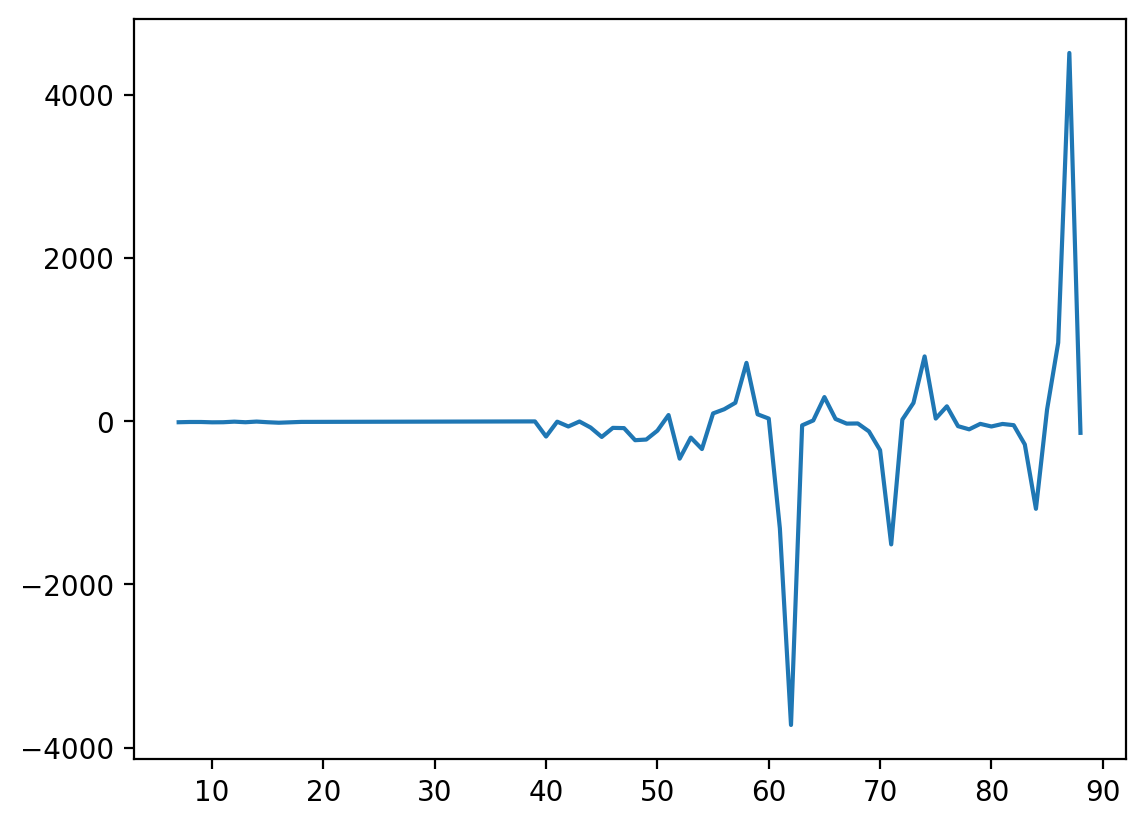

In [12]:
# ⑧ 추출된 특징 시각화하기
plt.plot(minimal_features_train['F_x__sum_values'])
plt.show()

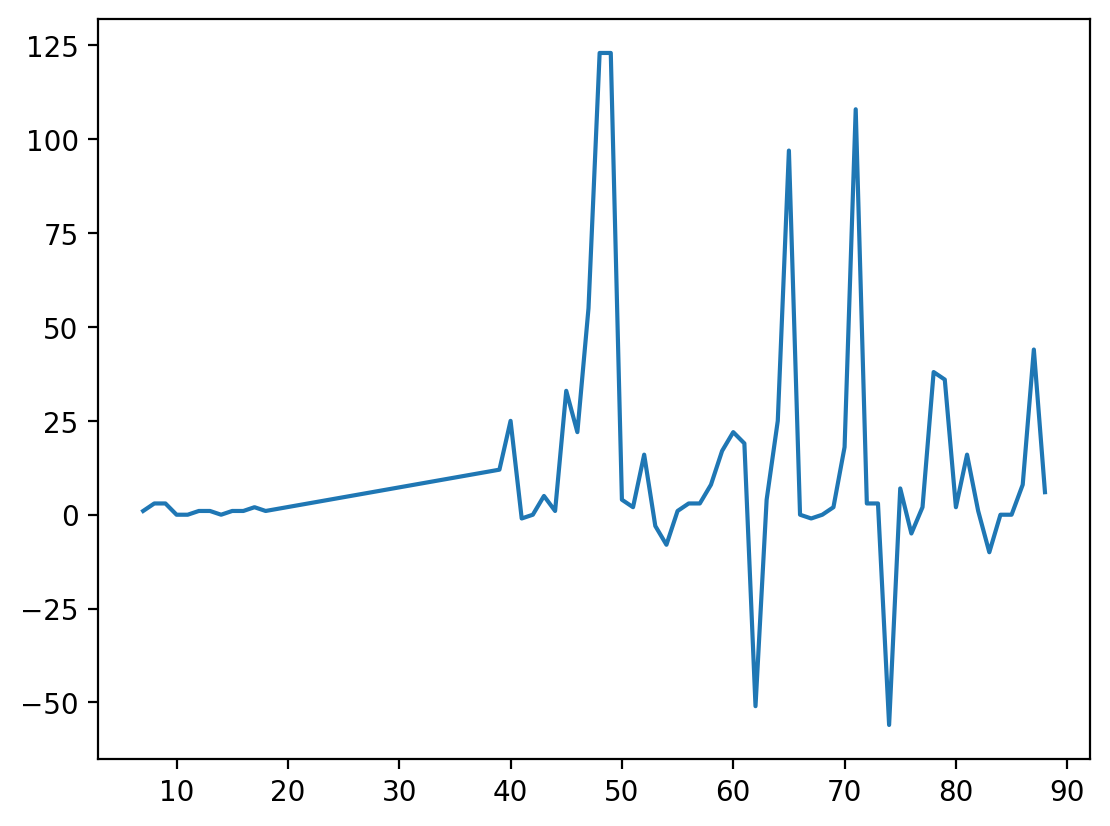

In [13]:
plt.plot(minimal_features_train['T_z__maximum'])
plt.show()


In [14]:
# ⑨ Logistic Regression 사용하기
logistic = LogisticRegression() 
logistic.fit(minimal_features_train, y_train)

LogisticRegression()

In [15]:
# ⑪ 분류 성능 평가 지표 확인하기
# y는 True, False는 Target으로도 표현할 수 있습니다. 
classification_report(y_test, logistic.predict(minimal_features_test), target_names=['true', 'false'], output_dict=True) # y_test 내부에 있는 true, false와 일치하는 이름을 표시합니다.

{'true': {'precision': 1.0,
  'recall': 0.6,
  'f1-score': 0.7499999999999999,
  'support': 20.0},
 'false': {'precision': 0.42857142857142855,
  'recall': 1.0,
  'f1-score': 0.6,
  'support': 6.0},
 'accuracy': 0.6923076923076923,
 'macro avg': {'precision': 0.7142857142857143,
  'recall': 0.8,
  'f1-score': 0.6749999999999999,
  'support': 26.0},
 'weighted avg': {'precision': 0.868131868131868,
  'recall': 0.6923076923076923,
  'f1-score': 0.7153846153846153,
  'support': 26.0}}

In [28]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Load dataset
ap = pd.read_csv('AirPassengers.csv')
ap

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [30]:
ap.drop('Month', axis=1, inplace=True)
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


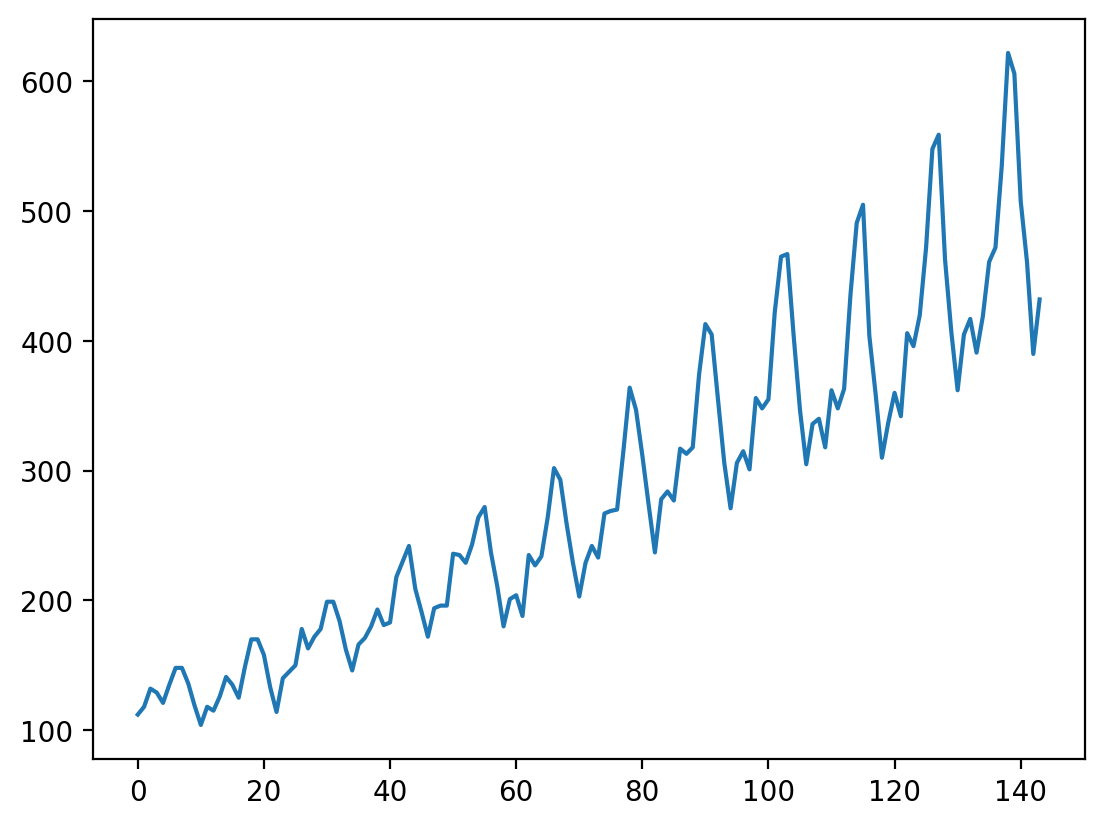

In [31]:
plt.figure()
plt.plot(ap)
plt.show()

In [32]:
# Log transformation
log_transformed = np.log(ap)
log_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


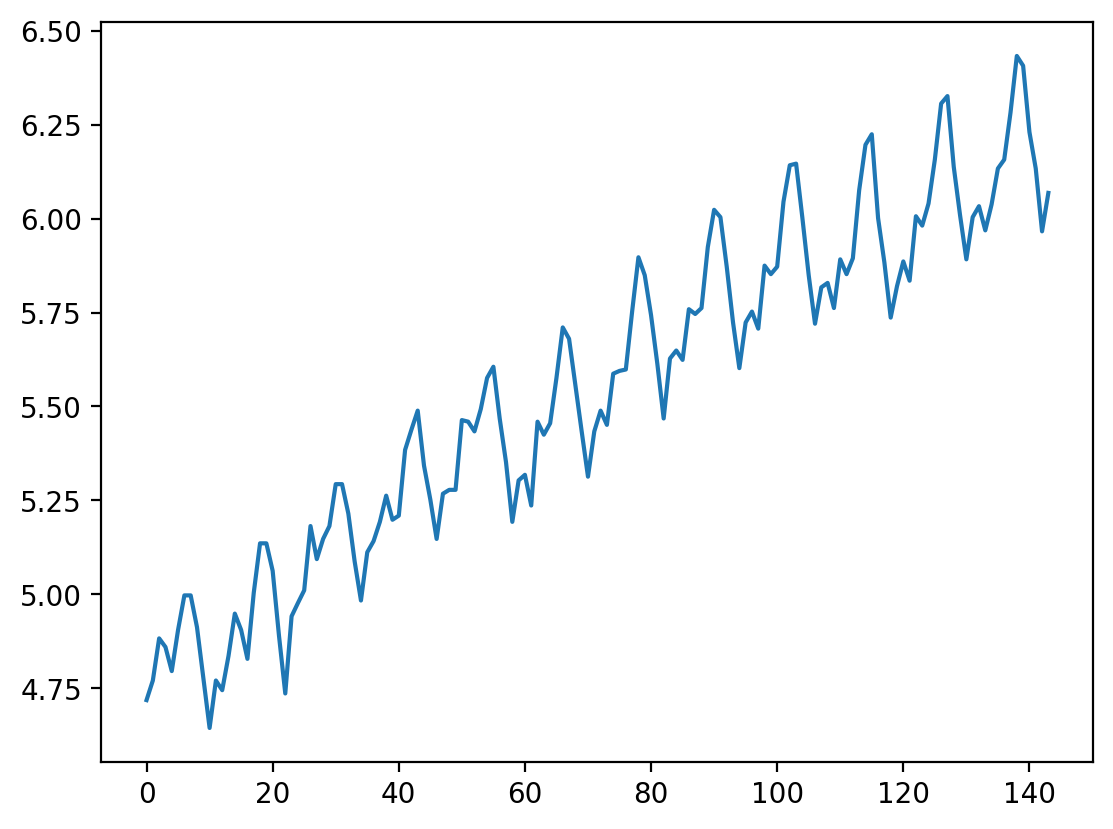

In [33]:
plt.figure()
plt.plot(log_transformed)
plt.show()

In [34]:
diffed = log_transformed.diff()
diffed

,#Passengers
0,NaN
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


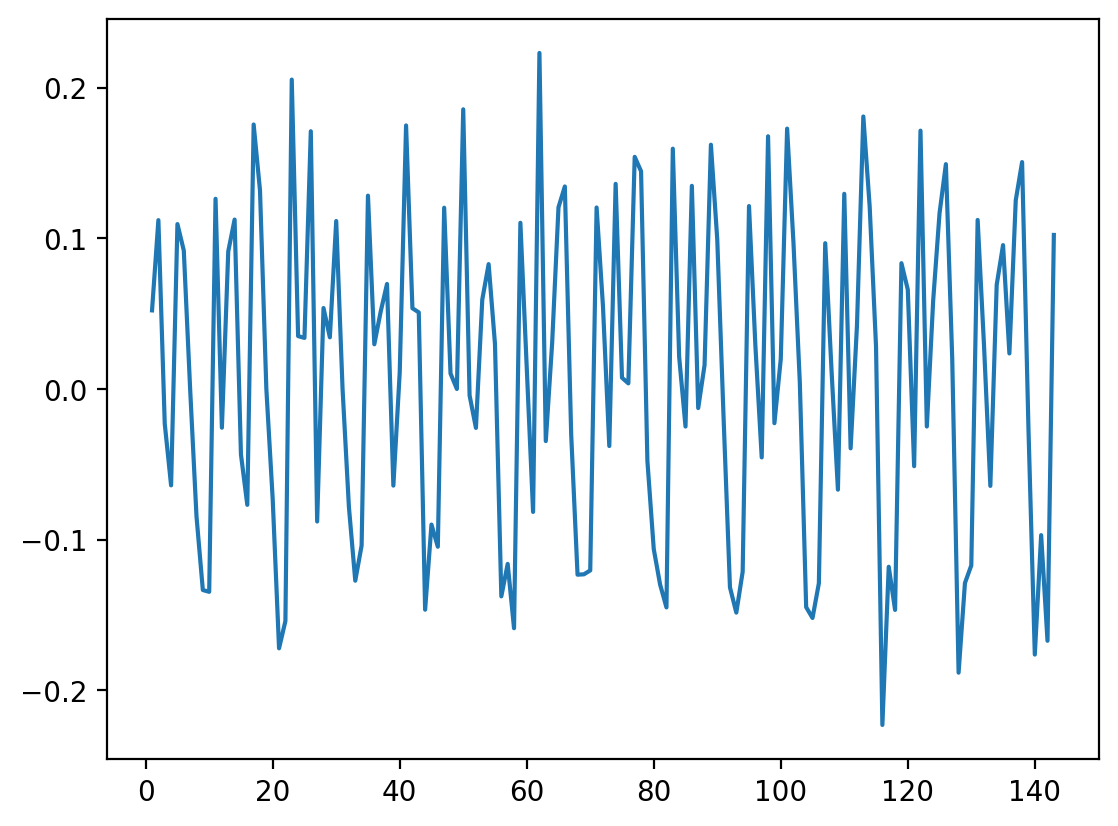

In [35]:
plt.figure()
plt.plot(diffed)
plt.show()

In [36]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있습니다.
seasonally_diffed = diffed.diff(12)
# 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 합니다.
seasonally_diffed.dropna(inplace = True)

In [37]:
# 형태를 확인해봅시다.
seasonally_diffed

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


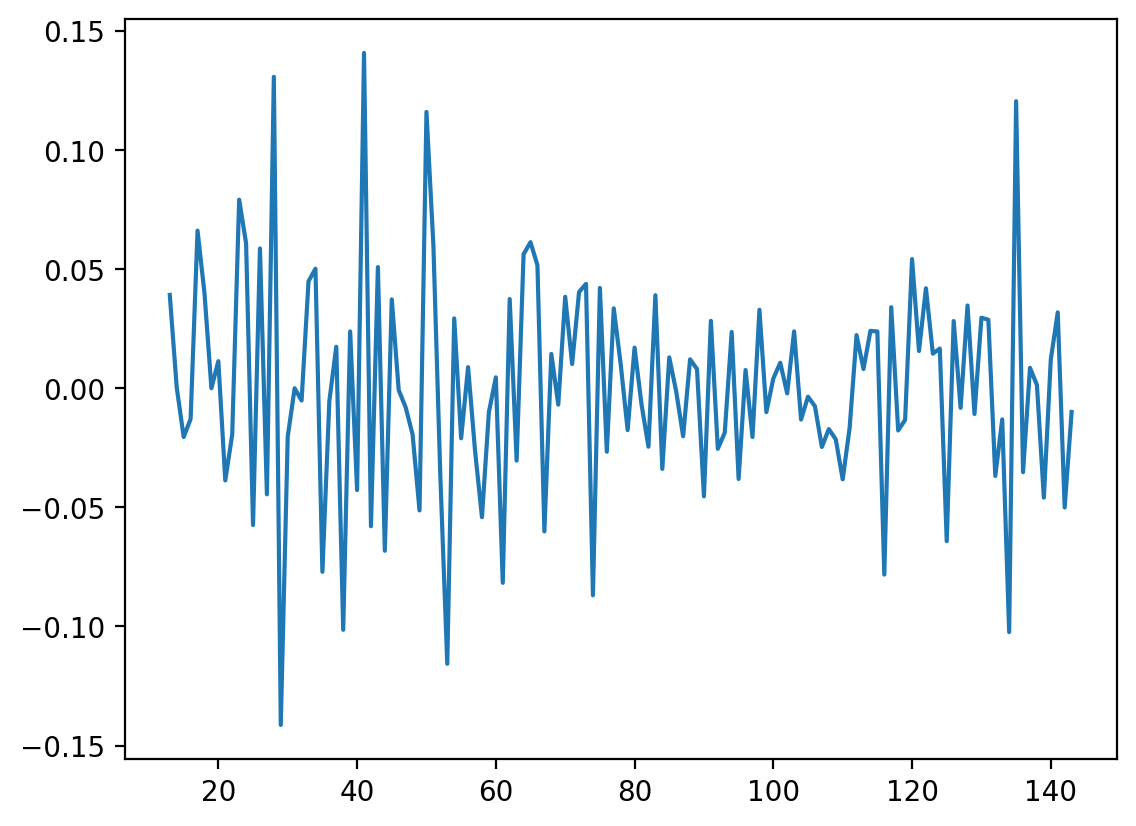

In [38]:
# 아래와 같은 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

In [40]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다.
    print('P-value')
    print(p_value) # P-value입니다.

In [41]:
adf_test(seasonally_diffed)

ADF statistics
-4.443324941831136
P-value
0.0002485912311383912


In [42]:
# ⑥-1 : 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러옵니다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [43]:
# ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
timeseries # id, time을 제외하고 6개 column의 X변수가 나타납니다.

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [44]:
y # true/false가 제시되어 있습니다.

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [45]:
# ⑥-3 : 데이터셋 가공
# def custom_classification_split(x,y,test_size=0.3): # 수업 때 보았던 custom split 함수
    
#     num_true = int(y.sum()*test_size)
#     num_false = int((len(y)-y.sum())*test_size)
    
#     id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
#     y_train = # [[YOUR CODE]]
#     y_test = # [[YOUR CODE]]
#     X_train = # [[YOUR CODE]]
#     X_test = # [[YOUR CODE]]
    
#     return X_train, y_train, X_test, y_test

def custom_classification_split(x, y, test_size=0.3):
    num_true = int(y.sum()*test_size)           # int(21 * 0.3) = 6
    num_false = int((len(y)-y.sum())*test_size) # int((88 - 21)*0.3) = 20

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    # y==False인것과 y==True인것의 인덱스값을 리스트로 변환하여 더해줍니다.
    # y[y==False].head(num_false).index.to_list()는 19~38까지의 값이 리스트로
    # y[y==True].head(num_true).index.to_list()는 1~6까지의 값이 리스트로 
    # id_list는 20~39 + 2~7이 더해진 리스트입니다.

    y_train = y.drop(id_list)                            # y에서 id_list를 drop합니다.  
    y_test = y.iloc[id_list].sort_index()                # 20~39, 2~7이 합쳐진 리스트를 정렬합니다.
    X_train = x[~x['id'].isin(id_list)] # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용하고 물결표시는 안에 조건이 포함되어 있지 않는것만 사용하는 것입니다.
    X_test = x[x['id'].isin(id_list)]   # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용

    return X_train, y_train, X_test, y_test

In [46]:
# ⑥-4 : 데이터셋 나누기
# test set의 비율을 0.25로 지정해주세요.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

In [47]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [48]:
# ⑥-5 : Feature extraction
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 24/24 [00:02<00:00,  8.61it/s]


In [49]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 21/21 [00:02<00:00, 10.40it/s]


In [50]:
# ⑥-6 : impute
impute(comprehensive_features_train)

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [51]:
impute(comprehensive_features_test)

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


In [102]:
# ⑥-7 : RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [103]:
# test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인할 수 있습니다.
rf_clf.score(comprehensive_features_test, y_test)

0.8095238095238095

In [62]:
# ⑥-7 : XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델을 학습시킵니다.
xgb_clf.fit(comprehensive_features_train, y_train)
xgb_clf_pred = xgb_clf.predict(comprehensive_features_test)
xgb_clf_pred_train = xgb_clf.predict(comprehensive_features_train)

In [55]:
# XGBoost 모델의 score를 확인합니다.
xgb_clf.score(comprehensive_features_test, y_test)

1.0

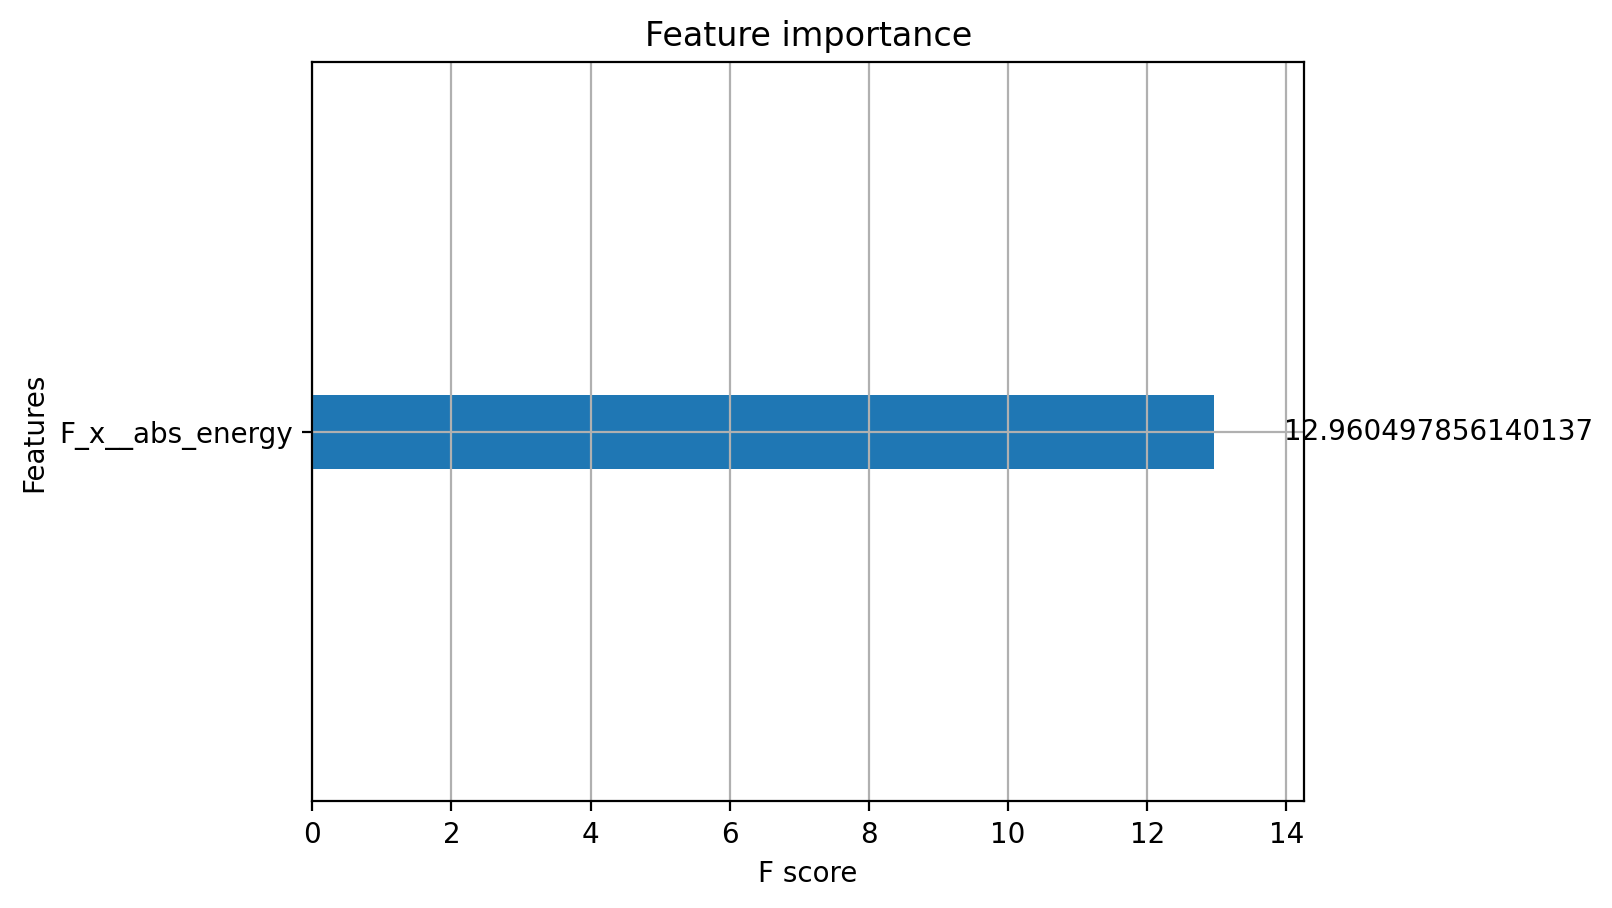

In [56]:
# ⑥-8 : XGBoost plot_importance 확인 및 시각화
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인합니다.
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [57]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

1

In [58]:
# ⑥-9 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0}}

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, xgb_clf_pred))
print(confusion_matrix(y_test, xgb_clf_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        16
        True       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

[[16  0]
 [ 0  5]]


In [63]:
print(classification_report(y_train, xgb_clf_pred_train))
print(confusion_matrix(y_train, xgb_clf_pred_train))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        51
        True       1.00      1.00      1.00        16

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

[[51  0]
 [ 0 16]]


In [91]:
feature_importance = pd.DataFrame(xgb_clf.feature_importances_, columns=['importance'])
feature_importance.sort_values('importance', ascending=False)


,importance
5,1.0
0,0.0
3106,0.0
3113,0.0
3112,0.0
...,...
1554,0.0
1553,0.0
1552,0.0
1551,0.0
